# TensorFlow Core

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print('version: {}'.format(tf.__version__))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

version: 2.9.2
Num GPUs Available:  1


## 初学者快速入门

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-19 13:43:41.905872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-19 13:43:41.906176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/5


2022-07-19 13:43:42.197936: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  10/1875 [..............................] - ETA: 10s - loss: 2.0832 - accuracy: 0.3125  

2022-07-19 13:43:42.461031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 10s 5ms/step - loss: 0.2900 - accuracy: 0.9155
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1386 - accuracy: 0.9590
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1015 - accuracy: 0.9695
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0818 - accuracy: 0.9747
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0679 - accuracy: 0.9788


2022-07-19 13:44:32.257442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 - 1s - loss: 0.0751 - accuracy: 0.9771 - 1s/epoch - 4ms/step


[0.07511437684297562, 0.9771000742912292]

## 专家快速入门

In [6]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [7]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [9]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [10]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [11]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [12]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [13]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [14]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

2022-07-19 13:46:29.687610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-19 13:46:40.694683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-19 13:46:41.976046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1, Loss: 0.14362534880638123, Accuracy: 95.55833435058594, Test Loss: 0.0621936097741127, Test Accuracy: 98.10000610351562
Epoch 2, Loss: 0.04509435594081879, Accuracy: 98.61500549316406, Test Loss: 0.05360954999923706, Test Accuracy: 98.21000671386719
Epoch 3, Loss: 0.023916995152831078, Accuracy: 99.21500396728516, Test Loss: 0.0649617612361908, Test Accuracy: 98.08000183105469
Epoch 4, Loss: 0.015112210065126419, Accuracy: 99.47833251953125, Test Loss: 0.05699760839343071, Test Accuracy: 98.2800064086914
Epoch 5, Loss: 0.009807934053242207, Accuracy: 99.67166900634766, Test Loss: 0.06284964829683304, Test Accuracy: 98.29000091552734


## Primary

### Keras 机器学习基础知识

#### 基本图形分类

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.9.2


In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
len(train_labels)

60000

In [7]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [8]:
test_images.shape

(10000, 28, 28)

In [9]:
len(test_labels)

10000

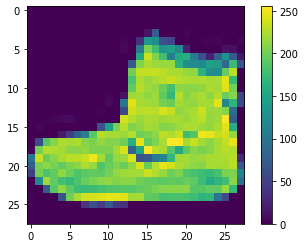

In [10]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [11]:
train_images = train_images / 255.0

test_images = test_images / 255.0

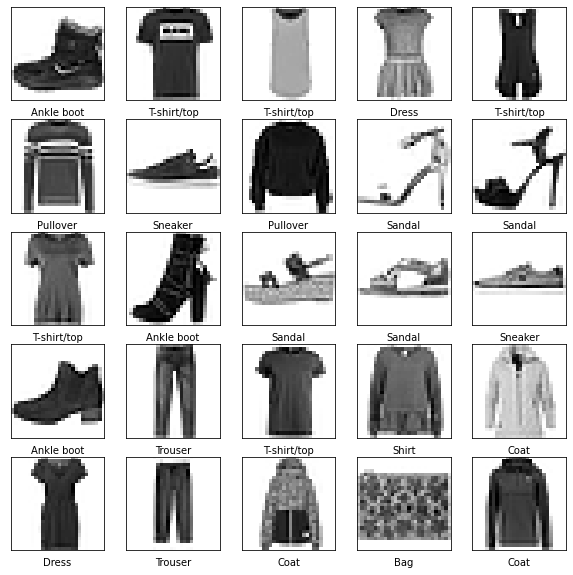

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [13]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-19 15:05:09.185797: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-19 15:05:09.186066: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10


2022-07-19 15:05:50.028091: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-19 15:05:50.204247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 10s 5ms/step - loss: 0.5058 - accuracy: 0.8218
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3759 - accuracy: 0.8638
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3372 - accuracy: 0.8764
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3145 - accuracy: 0.8842
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2943 - accuracy: 0.8916
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2811 - accuracy: 0.8955
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2683 - accuracy: 0.8997
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2576 - accuracy: 0.9040
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2458 - accuracy: 0.9091
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2398 - accur

In [16]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

2022-07-19 15:08:00.253166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 - 1s - loss: 0.3510 - accuracy: 0.8806 - 1s/epoch - 4ms/step

Test accuracy: 0.8806000351905823


In [17]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [18]:
predictions = probability_model.predict(test_images)

 94/313 [========>.....................] - ETA: 0s

2022-07-19 15:09:00.151956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 0s 1ms/step


In [19]:
predictions[0]

array([4.7706038e-07, 1.2026771e-09, 1.0755727e-09, 3.5874552e-07,
       1.4484083e-07, 1.6157540e-04, 2.7272904e-07, 1.3341236e-02,
       9.9498912e-08, 9.8649591e-01], dtype=float32)

In [20]:
np.argmax(predictions[0])

9

In [22]:
test_labels[0]

9

In [23]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

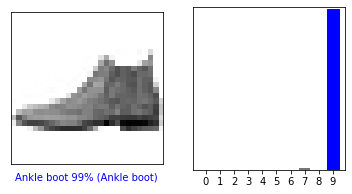

In [24]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

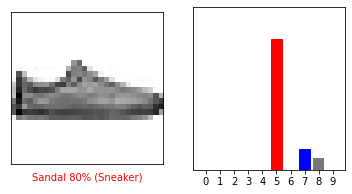

In [25]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

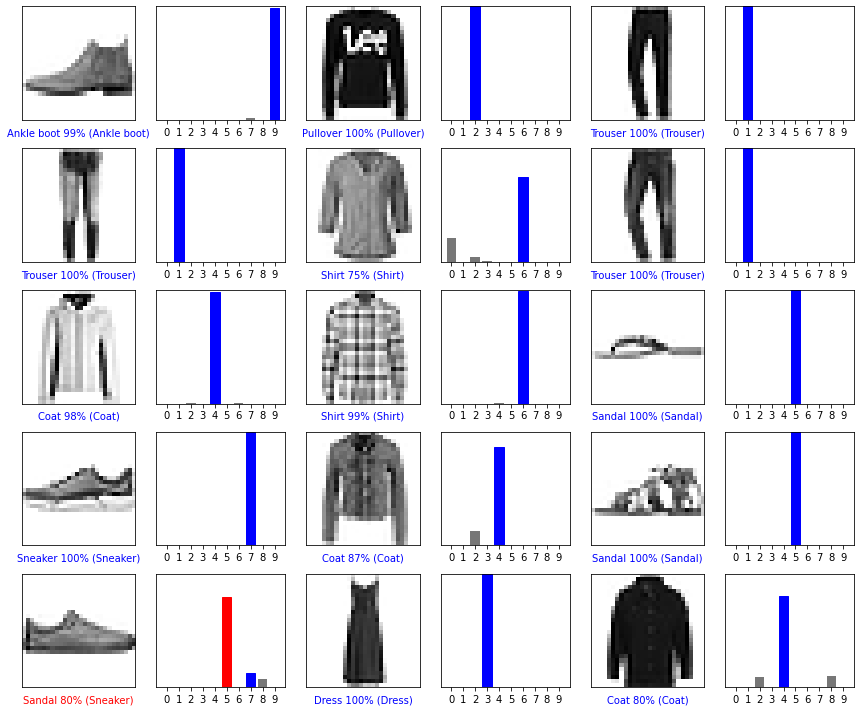

In [26]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [27]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


In [28]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [29]:
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 349ms/step
[[4.8254664e-05 7.4365888e-14 9.9941194e-01 6.8494055e-10 5.0822546e-04
  1.1408371e-10 3.1526106e-05 1.6891966e-15 3.0241818e-09 8.5656876e-15]]


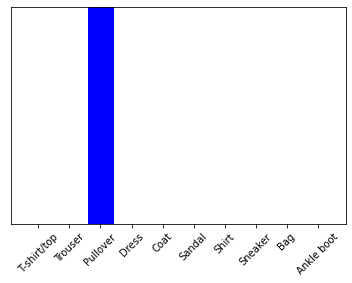

In [30]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [31]:
np.argmax(predictions_single[0])

2

#### 基本文本分类